In [6]:
''' Code written by William Bidle and Ilana Zane '''

__version__ = 'dev'

##########################################################################################
######################################## Imports #########################################
##########################################################################################

''' For Array Manipulation '''
import numpy as np

''' For Visualization '''
import matplotlib.pyplot as plt 

''' For Mathematical Expressions '''
from sympy import * 

''' For Runtime/Progress Checking '''
from tqdm import tqdm

''' For File Reading/Writing '''
import os
import json
import pickle

##########################################################################################
##########################################################################################
##########################################################################################

class NN:  
    def __init__(self, layer_sequence = [], loss_function = 'MSE'):
        
        ''' 
        ##################################################################
                    Initialize the Neural Network Class
        ##################################################################

        INPUTS:
        - layer_sequence (list) : a list containing the nodes per layer and correcponding activation functions between layers
        - loss_function (string) : the desired loss function to be used 

        OUTPUTS:
        - None

        ##################### Example ######################

        layer_sequence = [1,'ReLU', 2]
        loss_function = 'MSLE'
        
        nn = NN(layer_sequence, loss_function)

        # Avaliable Class Properties
        print('activation func library:\n', nn.activation_funcs_library)
        print()
        print('loss func library:\n', nn.loss_funcs_library)
        print()
        print('current weights:\n', nn.weights)
        print()
        print('current activation functions:\n', nn.activation_funcs)
        print()
        print('current loss function:\n', nn.loss_func_label, ':', nn.loss_func)
        print()
        print('traing error:\n', nn.training_err)
        
        '''
        
        self.activation_funcs_library = self.__load_func_libraries('activation_funcs_library.txt') # load in the function library        
        
        layers = layer_sequence[::2] # separate out the layer information
        if all(isinstance(item, int) for item in layers) == True: # check that the declared number of nodes is an integer
            layers = np.array(layer_sequence[::2], dtype = int) # set the *layers* property
            self.weights = self.__initialize_weights(layers) # initialize the *weights* property based off of the desired layer sequence
        else:
            raise Exception('Invalid Layer Sequence!') # raise an exception if the input layer sequence is improperly defined
            
        activation_funcs = layer_sequence[1::2] # separate out the activation function information
        if all(isinstance(item, str) for item in activation_funcs) == True: # check that the activation functions are strings
            self.activation_funcs = [] # initialize the *activation_funcs* property
            for i in range(len(activation_funcs)): # initialize each declared activation functions between layers
                self.activation_funcs.append(self.__init_func(self.activation_funcs_library, activation_funcs[i]))

        else:
            raise Exception('Invalid Layer Sequence!') # raise an exception if the input layer sequence is improperly defined
            
            
        self.loss_funcs_library = self.__load_func_libraries('loss_funcs_library.txt') # initialize the *loss_funcs_library* property
        self.loss_func = self.__init_func(self.loss_funcs_library, loss_function) # initialize the *loss_func* property
        self.loss_func_label = loss_function # initialize the *loss_func_label* property (used in plotting for now)
        
        self.training_err = None # initialize the *training_err* property (will be set later once the model is trained)

    ##########################################################################################
    #################################### Private Methods #####################################
    ##########################################################################################
    
    def __load_func_libraries(self, func_file):
    
        ''' 
        ##################################################################
            A method to load in dictionaries of available functions
        ##################################################################

        INPUTS:
        - func_file (string) : the filename containing the library of usable functions

        OUTPUTS:
        - func_library (dict) : a dictionary of the usable functions
        
        '''

        with open(func_file) as f: # open the desired file
            data = f.read()
      
        func_library = json.loads(data) # reconstruct the data as a dictionary
        
        return func_library
        
    ##########################################################################################

    def __init_func(self, func_library, func_name):

        ''' 
        ##################################################################
                Initialize a function from a function library
        ##################################################################

        INPUTS:
        - func_library (dict) : a dictionary of the usable functions
        - func_name (string) : the name of the mathematical function to be initialized (e.g., 'sigmoid')

        OUTPUTS:
        - expression (sympy.core.symbol.Symbol) : symbolic mathematical representation of 'func_name'

        '''

        try: # try to initialize the function
            expression = func_library[func_name]
            
        except: # if the function doesn't exist within the function library, return an exception
            raise Exception("Desired function '%s' does not exist within the 'func_library.'" % func_name)
            
        x, y, y_hat = symbols('x y y_hat', real = True) # declare the variables of interest (x for activations, y and y_hat for loss)
        expression = parse_expr(expression, local_dict = {'x': x, 'y': y, 'y_hat': y_hat}) # parse throught the expression
        
        return expression

    ##########################################################################################

    def __eval_func(self, expression, vals, diff = False):

        ''' 
        ##################################################################
                        Initialize an activation function
        ##################################################################

        INPUTS:
        - expression (sympy.core.symbol.Symbol) : symbolic mathematical representation of 'func'
        - vals (2D list) : the values to evaluate 'expression' with
            |
             ---> 1 sub-list for activation functions (x information), 2 sub-lists for loss functions (y, y_hat information)
        - diff (Boolean) : whether or not to evaluate the derivitive of 'expression' at 'vals
        
        OUTPUTS:
        - result (if diff = False ---> Float, if diff = True ---> NumPy 1D array) : evaluation of 'expression' at '_input_'                   

        '''        
        
        if expression in self.activation_funcs: # Evaluate Activation Functions
            x = Symbol('x', real = True) # the variable of interest

            if diff == True: # differentiate only if the 'diff' flag is True
                expression = expression.diff(x)

            func = lambdify(x, expression) # allow the function to be evaluated from lists
            result = func(vals[0]) # evaluate the function at the given input
            
            return result
            
        
        else: # Evaluate Loss Functions
            y, y_hat = symbols('y, y_hat', real = True) # the variables of interest
            
            if diff == True: # differentiate only if the 'diff' flag is True
                expression = expression.diff(y)
                
                func = lambdify((y, y_hat), expression) # allow the function to be evaluated from lists
                result = func(vals[0], vals[1]) # evaluate the function at the given input
                return result
            
            func = lambdify((y, y_hat), expression) # allow the function to be evaluated from lists
            result = func(vals[0], vals[1]) # evaluate the function at the given input
            return sum(result)
    
    ##########################################################################################
    
    def __initialize_weights(self,layers):
        
        ''' 
        ##################################################################
                    Initialize the weights of the network 
        ##################################################################

        INPUTS:
        - layers (1D Numpy Array) : an array containing the layer information of the network
        
        OUTPUTS:
        - weights (3D list) : list containing the (potentially different sized) 2D weight arrays between the different layers       

        '''        
        
        layers_reorganized = np.flip(layers.repeat(2)[1:-1].reshape(len(layers)-1,2), axis = 1)

        weights = [] # initialize the list of the weights between different layers
        for i in range(len(layers_reorganized)):
            weight = np.random.randn(layers_reorganized[i][0], 
                                     layers_reorganized[i][1] + 1) # include bias vector with the '+ 1'
            weights.append(weight*np.sqrt(2/layers_reorganized[i][1])) # HE initialization for weights

        return weights
        
    ##########################################################################################

    def __update_weights(self, weights, layer_values, _label_):
        
        ''' 
        ##################################################################
                        Update the weights of the network 
        ##################################################################

        INPUTS:
        - weights (3D list) : list containing the (potentially different sized) 2D weight arrays between the different layers 
        - layer_values (2D list) : list containing the values of each layer for a given input value (see method 'get_network_outputs' below)
        - _label_ (1D NumPy Array) : array representation for the current label (usually one hot ecoded, see method 'One_Hot_Encode' below)
        
        OUTPUTS:
        - weight_updates, weights (3D list) : list containing the updated 2D weight arrays between the different layers
        - weights (3D list) : list containing the original 2D weight arrays between the different layers       

        '''  
    
        activations = self.activation_funcs # get the list of desired activation functions

        ''' Debug '''
        # print('layer_values:', layer_values)
        # print('weights:', weights)
        # print()

        weight_updates = weights.copy() # make a copy of the weights so they aren't changed

        blue = np.diag(self.__eval_func(self.loss_func, [layer_values[-1], _label_], diff = True)) # blue in notes
        
        ''' Debug '''
        # print('blue:', blue.shape)
        # print()

        layer_output = np.dot(weights[-1],np.concatenate((layer_values[-2], [1]))) # need to add an extra component to input for bias
        red = self.__eval_func(activations[-1], [layer_output], diff = True) # red in notes
        
        ''' Debug '''
        # print('red:', red.shape)
        # print()

        
        for i in range(len(weights), 0, -1): # index through each weight (work backwards)
            ''' Debug '''
            # print('index i:', i - 1)

            pink = np.concatenate((layer_values[i-1], [1])) # pink in notes 
            ''' Debug '''
            # print('pink:', pink.shape)
            # print()

            grad = np.matmul(blue, np.outer(red, pink)) # first two terms in gradient
            ''' Debug '''
            # print('grad1:', grad.shape)
            # print()

            for j in range(len(weights), i, -1): # look forwards through each weight (only if there are forward weights)
                ''' Debug '''
                # print('index j:', j - 1)

                orange = np.transpose(weights[j-1]) # orange in notes
                ''' Debug '''
                # print('orange:', orange.shape)
                # print()

                green = np.diag(self.__eval_func(activations[j-1], [np.dot(weights[j-2],np.concatenate((layer_values[j-2], [1])))], diff = True)) # green in notes
                bias_vec = np.ones((len(green),1)) # add on the bias vector to make sure dimensions work properly
                green = np.hstack((green,bias_vec)) # incorperate the bias
                ''' Debug '''
                # print('green:', green.shape)
                # print()

                grad = np.matmul(green,np.matmul(orange,grad)) # now multiply the rest to grad
                ''' Debug '''
                # print('grad2:', grad.shape)
                # print()

            weight_updates[i-1] = grad # record the change in weight

        return weight_updates, weights
    
    ##########################################################################################
    #################################### Public Methods ######################################
    ##########################################################################################
    
    def get_network_outputs(self, weights, _input_):
        
        activations = self.activation_funcs # get the list of desired activation functions
        
        current_layer = _input_
        network_outputs = [current_layer] # add the first layer to the list

        for i in range(len(weights)):

            layer_output = np.dot(weights[i],np.concatenate((current_layer, [1]))) # need to add an extra component to input for bias
            current_layer = self.__eval_func(activations[i], [layer_output], diff = False)
            
            network_outputs.append(current_layer)
     
        return network_outputs

    ##########################################################################################

    def compute_error(self, _result_, _label_):
        
        error = self.__eval_func(self.loss_func, [_result_, _label_])

        return error

    ##########################################################################################
    
    def train(self, x_train, y_train, batch_size = 1, epochs = 1, epsilon = 1, visualize = False):
            
        weights = self.weights # get the list of weights 

        error_list = []

        counter = 0 # keep track of the current iteration

        weights_list = {} # create a dictionary to keep track of the weight updates (batch size)
        for i in range(len(weights)):
            weights_list[i] = [] # just a temporary blank array since training hasn't begun yet
        
        #create epochs 
        
        for i in range(epochs):
        
        
            # the training
            for _input_, _label_ in tqdm(zip(x_train, y_train), total = len(x_train), desc = 'Epoch %s'%str(i+1)): # iterate through the inputs and labels

                network_output = self.get_network_outputs(weights, _input_) # the current network output

                error = self.compute_error(network_output[-1], _label_)

                weight_updates, weights = self.__update_weights(weights, network_output, _label_)

                for j in range(len(weights)):
                    weights_list[j].append(weight_updates[j])

                counter += 1

                if (counter) % batch_size == 0: 
                    for j in range(len(weights)):

                        weights[j] -= epsilon*np.average(np.array(weights_list[j]), axis = 0)
                        weights_list[j] = []

                error_list.append(error)

            self.weights = weights
            self.training_err = error_list
        
        if visualize == True:
            fig, ax = plt.subplots(figsize = (12,6))
            
            ax.plot(self.training_err) # to visualize error over time
            
            ax.set_xlabel('Training Sample', fontsize = 14)
            ax.set_ylabel('%s Error' % self.loss_func_label, fontsize = 14)
            
            ax.grid(linestyle = '--')
            
            plt.show()
    
    ##########################################################################################
    
    def evaluate(self, x_test):

        results = []

        for _input_ in tqdm(x_test, desc = 'Evaluating Test Data', total = len(x_test)):
            network_output = self.get_network_outputs(self.weights, _input_) # the current network output
            results.append(network_output[-1])
            
        return results
            
    ##########################################################################################
    
    def save_model(self, filename = 'Saved_Model'):

        save_path = 'Saved Models/' + filename
        
        to_save = [self.weights, self.activation_funcs] # save both the activations and weights
        with open(save_path, "wb") as fp: # save the weights and activations
            pickle.dump(to_save, fp)
            
        print()
        print('Model saved at %s' % save_path)
        print()
        
    ##########################################################################################
    ##########################################################################################
    ##########################################################################################
    
##########################################################################################
################################## Other Useful Methods ##################################
##########################################################################################

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def One_Hot_Encode(labels):
    num_unique_elements = np.unique(labels)
    
    dic = {}
    counter = 0
    for i in num_unique_elements:
        if i in dic:
            pass
        else:
            dic[i] = counter
            counter += 1
            
    encoded_labels = np.zeros((len(labels), len(num_unique_elements)))
    
    for i in range(len(labels)):
        encoded_labels[i][dic[labels[i]]] = 1.
        
    return encoded_labels

def load_model(filename = 'Saved_Model'):

    load_path = 'Saved Models/' + filename
    
    with open(load_path, "rb") as fp: # Unpickling
        loaded = pickle.load(fp)

    weights = loaded[0]
    activations = loaded[1]
    
    nn = NN() # initialize a blank Neural Network
    nn.weights = weights
    nn.activation_funcs = activations

    return nn
##########################################################################################
##########################################################################################
##########################################################################################

In [7]:
''' For Dataset Usage '''
from keras.datasets import mnist

In [8]:
########################### Training Data Prep ###########################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

num_data_pts = 1000

x_train = x_train[0:num_data_pts]
y_train = One_Hot_Encode(y_train[0:num_data_pts])

input_shape = x_train[0].size
output_shape = y_train[0].size

########################### Testing Data Prep ############################

num_test_evals = 1000

x_test = x_test[0:num_test_evals]
y_test = One_Hot_Encode(y_test[0:num_test_evals])

##########################################################################

Epoch 1: 100%|██████████| 1000/1000 [00:10<00:00, 99.49it/s]


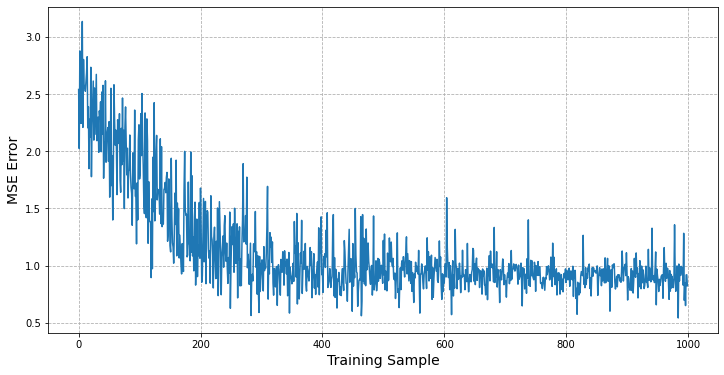

Evaluating Test Data: 100%|██████████| 1000/1000 [00:02<00:00, 446.30it/s]


Model saved at Saved Models/Saved_Model



In [9]:
############################## Build network ##############################

# layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]
layer_sequence = [input_shape, 'ReLU', 100, 'sigmoid', output_shape] # initialize the layer sequences and corresponding activations

loss_function = 'MSE' # declare the loss function

nn = NN(layer_sequence, loss_function) # Build a model 

################################# Run it ##################################

nn.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

################################# Testing ##################################

results = nn.evaluate(x_test)

nn.save_model()

# Softmax Developmemnt

In [1]:
from sympy import *

In [2]:
x, n, i, j = symbols('x, n, i, j')
s = exp(Indexed('x',1))/Sum(exp(Indexed('x',i)),(i,1,2)).doit()
display(s)

diff = simplify(s.diff(Indexed('x',1)))
display(diff)

f = lambdify(Indexed('x',1), s)
f(1)

exp(x[1])/(exp(x[1]) + exp(x[2]))

exp(x[1] + x[2])/(2*exp(x[1] + x[2]) + exp(2*x[1]) + exp(2*x[2]))

TypeError: 'Symbol' object is not subscriptable

In [3]:
x, i, n = symbols("x i n")
s = exp(Indexed('x',j))/Sum(exp(Indexed('x',i)),(i,0,n))
display(s)
b = np.array([1, 2, 3])
s = s.subs(n, len(b)-1)

display(s.doit())

# f = lambdify(x, s)
# print(f(b))

# matrix = []
# for index, value in enumerate(b):
#     f = s.subs(x, Indexed('x', index))
#     matrix.append(f.diff(Indexed('x',index)))

#     matrix = Matrix(matrix)
# display(matrix)

diff = s.diff(Indexed('x',i))
display(diff)
# # diff = diff.subs(Indexed('x',0), x)
display(simplify(diff.doit()))

g = lambdify(x, diff)
print(g(b))

1

exp(x[j])/Sum(exp(x[i]), (i, 0, n))

NameError: name 'np' is not defined

In [4]:
x, i, n = symbols("x i n")
s = Indexed('x',i)
display(s)
b = np.array([1, 2, 3, 4])
# s = s.subs(n, len(b))
display(s.doit())

f = lambdify(x, s)
print(f(b))

x[i]

NameError: name 'np' is not defined